# County quadrants

This analysis assigns each county in California to one of 4 quadrants defined by 2 dimensions:
- low or high climate model uncertainty
- low or high social vulnerability 



In [1]:
# Setup
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import scipy
import sys
import xarray as xr

root_dir = "../../"
code_dir = root_dir + "code/"
data_dir = root_dir + "data/"

# for importing helper code
sys.path.append(code_dir)
import uncertainty_metrics as UM
# from utils import *

# colormap for temperatures
temp_cmap = 'hot_r' 

# colormap for differences
diff_cmap = 'viridis'


## CA Counties
downloaded from https://data.ca.gov/dataset/ca-geographic-boundaries/resource/b0007416-a325-4777-9295-368ea6b710e6

In [17]:
# convert to a lat/lon CRS
df_counties = gpd.read_file(data_dir + "tiger/CA_Counties/CA_Counties_TIGER2016.shp").to_crs('EPSG:4269')

<AxesSubplot:>

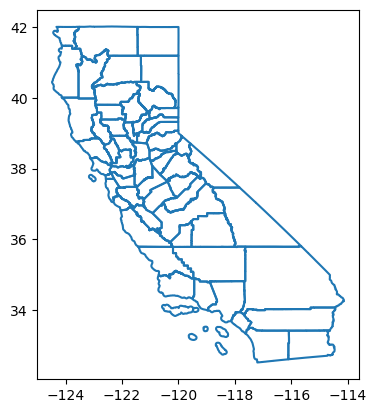

In [18]:
df_counties.boundary.plot()

## CA PUMA polygons

In [19]:
df_pumas = gpd.read_file(data_dir + "tiger/tl_2018_06_puma10/tl_2018_06_puma10.shp")

<AxesSubplot:>

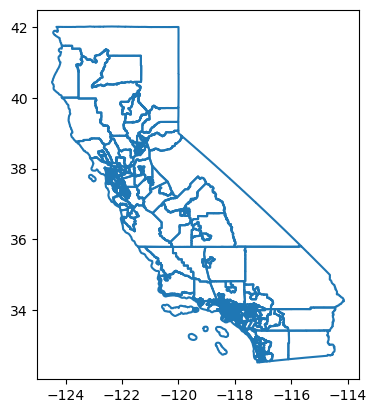

In [20]:
df_pumas.boundary.plot()

## Climate model uncertainty


### Calculate metrics
Do several metrics, and calculate range across each metric.

Starting metrics:
- 1-in-20 return value in 2050
- Average hottest annual hour from 2040 to 2060
- Average summer daily max
- Average summer weekly cooling degree hours
- [TO DO]:1-in-10 RV for a three-day long heat wave?

These are calculated on the CalAdapt Analytics Engine hub for performance (using `climakitae`). Code in `code` directory, data files saved in `data/CalAdapt`.

#### 1-in-20 return value
Using 30 years of data starting in 2050.

In [7]:
# Dataset has variables for Return Value and for hi and lo confidence intervals
ds_rvs = xr.open_dataset(data_dir + 'CalAdapt/CA_rvs20_2050_ssp37.nc')

# Access the return values variable for now
da_rvs = ds_rvs['return_value'].drop('scenario')

#### Avg hottest annual hour from 2040 to 2060

In [8]:
# Get annual max dataset
da_ams = xr.open_dataset(data_dir + "CalAdapt/CA_ams_ssp37.nc")['Air Temperature at 2m']

# Calculate average
da_avg_2050 = da_ams.sel(time = slice("2040", "2059")).mean(dim='time').drop('scenario') # `squeeze` drops the scenario dimension (which only has one scenario)

#### Avg summer daily max (from 2045 to 2055)

In [9]:
da_summer_max = xr.open_dataset(data_dir + "CalAdapt/CA_avg_summer_daily_max_2045_2055.nc")['Daily maximum air temperature at 2m'].drop('scenario')

In [ ]:
# sum(np.isnan(da_summer_max.isel(scenario=0, simulation=0).values))

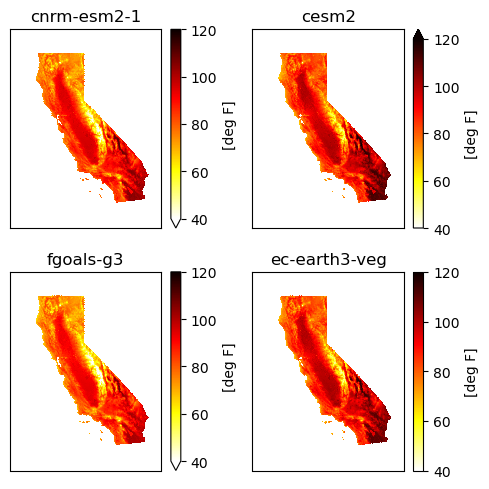

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(5, 5))

for (sim, ax) in zip(da_summer_max.simulation, axes.ravel()):

    da_summer_max.sel(simulation=sim).plot(
        ax=ax, x='lon', y='lat', 
        cmap=temp_cmap, 
        cbar_kwargs={'label': "[deg F]"},
        vmax=120, vmin=40
        )

    ax.set_title(sim.item())
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.tick_params(left = False, right = False , labelleft = False ,
        labelbottom = False, bottom = False)

plt.tight_layout()

#### Avg summer CDH

average daily cooling degree hours in summer from 2045-2055

In [4]:
da_summer_CDH = xr.open_dataset(data_dir + "CalAdapt/CA_avg_summer_CDH_2050.nc")['Air Temperature at 2m'].drop('scenario')

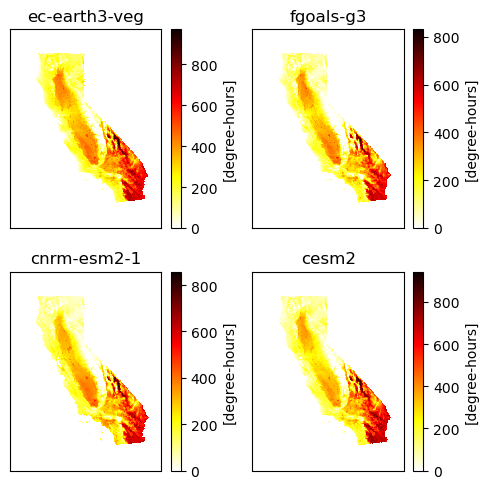

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(5, 5))

for (sim, ax) in zip(da_summer_CDH.simulation, axes.ravel()):

    da_summer_CDH.sel(simulation=sim).plot(
        ax=ax, x='lon', y='lat', 
        cmap=temp_cmap, 
        cbar_kwargs={'label': "[degree-hours]"},
        # vmax=120, vmin=40
        )

    ax.set_title(sim.item())
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.tick_params(left = False, right = False , labelleft = False ,
        labelbottom = False, bottom = False)

plt.tight_layout()

#### Avg summer CH
average number of hours per day in summer that are above 65F

In [12]:
da_summer_CH = xr.open_dataset(data_dir + "CalAdapt/CA_avg_summer_CH_2050.nc")['Air Temperature at 2m'].drop('scenario')

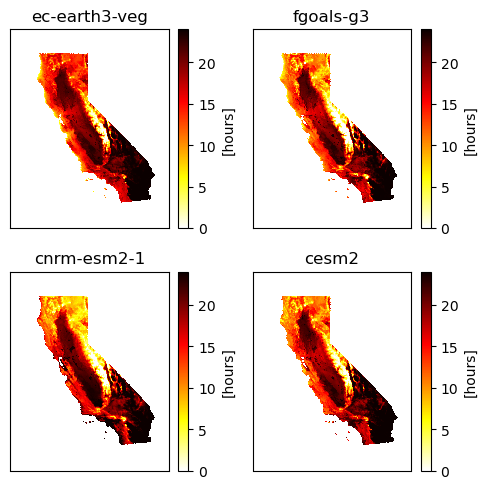

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(5, 5))

for (sim, ax) in zip(da_summer_CH.simulation, axes.ravel()):

    da_summer_CH.sel(simulation=sim).plot(
        ax=ax, x='lon', y='lat', 
        cmap=temp_cmap, 
        cbar_kwargs={'label': "[hours]"},
        # vmax=120, vmin=40
        )

    ax.set_title(sim.item())
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.tick_params(left = False, right = False , labelleft = False ,
        labelbottom = False, bottom = False)

plt.tight_layout()

#### [TO DO] other metrics

### Put all metrics into one dataset and calculate range

In [14]:
ds_clim_metrics = xr.Dataset(
    {
        'return_value' : da_rvs,
        'cv_return_value' : UM.cv(da_rvs),
        'diff_return_value' : UM.max_diff(da_rvs),

        'avg_max' : da_avg_2050,
        'cv_avg_max' : UM.cv(da_avg_2050),
        'diff_avg_max' : UM.max_diff(da_avg_2050),

        'avg_summer_daily_max' : da_summer_max,
        'cv_avg_summer_daily_max' : UM.cv(da_summer_max),
        'diff_avg_summer_daily_max' : UM.max_diff(da_summer_max),

        'avg_summer_CDH' : da_summer_CDH,
        'cv_avg_summer_CDH' : UM.cv(da_summer_CDH),
        'diff_avg_summer_CDH' : UM.max_diff(da_summer_CDH),

        'avg_summer_CH' : da_summer_CH,
        'cv_avg_summer_CH' : UM.cv(da_summer_CH),
        'diff_avg_summer_CH' : UM.max_diff(da_summer_CH),
    }
)
ds_clim_metrics

c:\Users\corak\anaconda3\envs\masters\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\corak\anaconda3\envs\masters\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\corak\anaconda3\envs\masters\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.Dataset>
Dimensions:                    (simulation: 4, y: 433, x: 179, scenario: 1)
Coordinates:
  * simulation                 (simulation) object 'cesm2' ... 'fgoals-g3'
  * y                          (y) float64 5.449e+05 5.479e+05 ... 1.841e+06
  * x                          (x) float64 -4.278e+06 -4.275e+06 ... -3.744e+06
    lakemask                   (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    landmask                   (y, x) float32 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0
    lat                        (y, x) float32 30.94 30.95 30.97 ... 43.48 43.5
    lon                        (y, x) float32 -117.8 -117.8 ... -121.6 -121.5
    Lambert_Conformal          int64 0
Dimensions without coordinates: scenario
Data variables: (12/15)
    return_value               (simulation, y, x) float64 nan nan ... nan nan
    cv_return_value            (y, x) float64 nan nan nan nan ... nan nan nan
    diff_return_value          (y, x) float64 nan nan nan nan ... nan nan nan
    avg_max                    (scenario, simulation, y, x) float32 nan ... nan
    cv_avg_max                 (scenario, y, x) float32 nan nan nan ... nan nan
    diff_avg_max               (scenario, y, x) float32 nan nan nan ... nan nan
    ...                         ...
    avg_summer_CDH             (scenario, simulation, y, x) float32 0.0 ... 0.0
    cv_avg_summer_CDH          (scenario, y, x) float32 nan nan nan ... nan nan
    diff_avg_summer_CDH        (scenario, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    avg_summer_CH              (scenario, simulation, y, x) float64 0.0 ... 0.0
    cv_avg_summer_CH           (scenario, y, x) float64 nan nan nan ... nan nan
    diff_avg_summer_CH         (scenario, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0

### Plot each metric at each grid cell

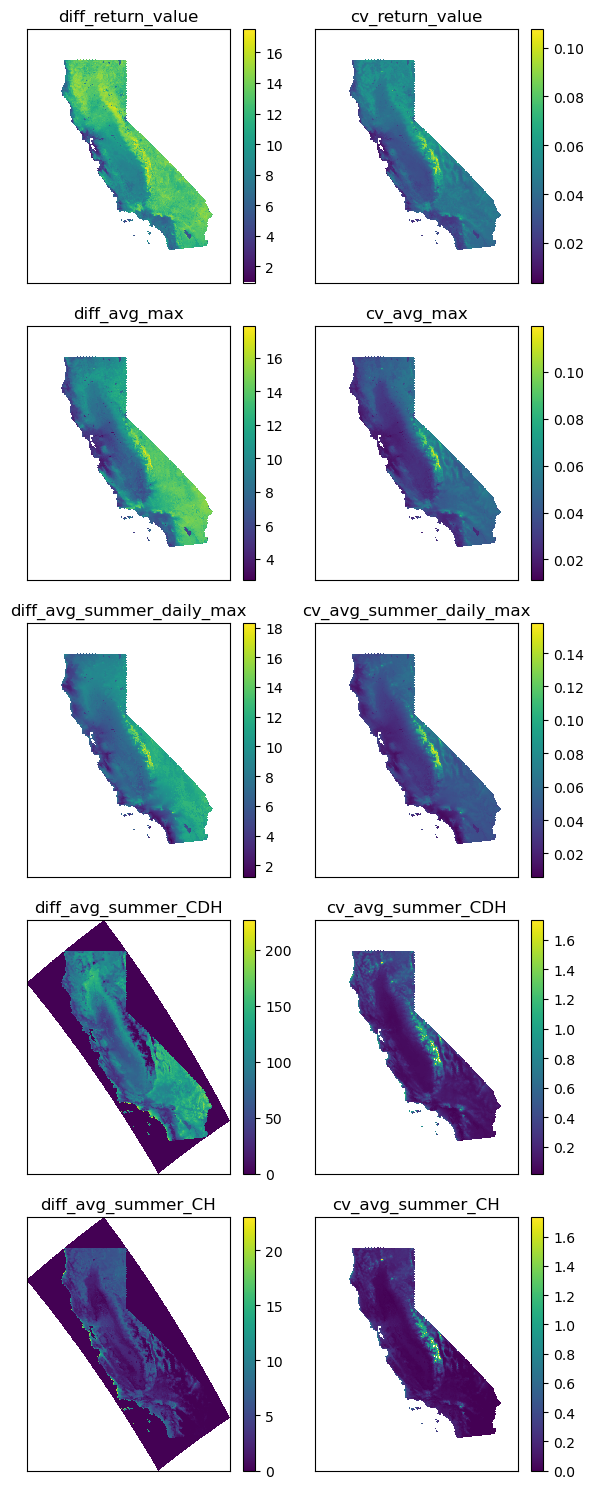

In [15]:
uncertainty_metrics = [
    'diff_return_value', 'cv_return_value', 
    'diff_avg_max', 'cv_avg_max', 
    'diff_avg_summer_daily_max', 'cv_avg_summer_daily_max',
    'diff_avg_summer_CDH', 'cv_avg_summer_CDH',
    'diff_avg_summer_CH', 'cv_avg_summer_CH'
    ]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(6, 15))

for (metric, ax) in zip(uncertainty_metrics, axes.ravel()):

    ds_clim_metrics[metric].plot(
        ax=ax, x='lon', y='lat', 
        cmap='viridis', 
        cbar_kwargs={'label': ''},
        # vmax=130, vmin=70
        )

    ax.set_title(metric)
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.tick_params(left = False, right = False , labelleft = False ,
        labelbottom = False, bottom = False)

plt.tight_layout()

### Categorize each county
For each county, assign low or high based on ??
- start with: calculate average max_diff within each county and plot by county

In [21]:
# Have to turn xarray into GDF in order to combine with county boundary info

df = ds_clim_metrics['diff_return_value'].to_dataframe().reset_index()

data_dict = dict([(um, ds_clim_metrics[um].to_dataframe().reset_index()[um]) for um in uncertainty_metrics])

climate_gdf = gpd.GeoDataFrame(
    data = data_dict,
    geometry=gpd.points_from_xy(df.lon, df.lat)
)

climate_gdf_counties = df_counties.sjoin(climate_gdf)
climate_gdf_county_avg = climate_gdf_counties.groupby("GEOID")[uncertainty_metrics].aggregate(np.mean)
climate_gdf_county_avg = pd.merge(df_counties, climate_gdf_county_avg, how="left", on="GEOID")

c:\Users\corak\anaconda3\envs\masters\lib\site-packages\geopandas\geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


<AxesSubplot:>

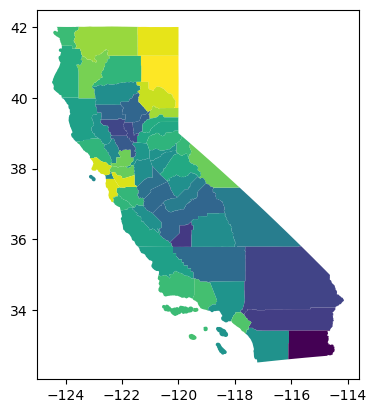

In [22]:
climate_gdf_county_avg.plot(column = 'diff_avg_summer_CH')

In [ ]:
# Plot the assignments

### Categorize each PUMA

In [23]:
climate_gdf_pumas = df_pumas.sjoin(climate_gdf)
climate_gdf_puma_avg = climate_gdf_pumas.groupby("GEOID10")[uncertainty_metrics].aggregate(np.mean)
climate_gdf_puma_avg = pd.merge(df_pumas, climate_gdf_puma_avg, how="left", on="GEOID10")

c:\Users\corak\anaconda3\envs\masters\lib\site-packages\geopandas\geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


<AxesSubplot:>

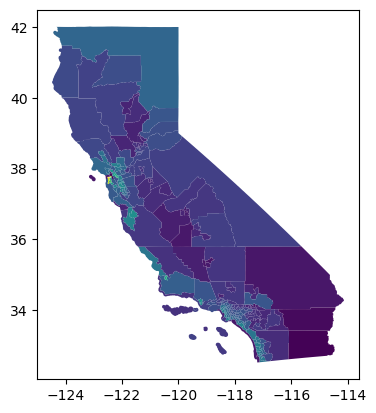

In [24]:
climate_gdf_puma_avg.plot(column = 'diff_avg_summer_CH')

### Bay Area

## Social vulnerability

For each county, assign low or high based on PUMA's within the county

## Assign quadrants

### Plot

### Map